In [8]:
from IPython.display import HTML
import pandas as pd
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [15]:
df = pd.read_csv('data/telemetry.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

version_A = df[df.game_version=='A']
version_B = df[df.game_version=='B']

total_users_A = len(pd.unique(version_A['user_id']))
total_users_B = len(pd.unique(version_B['user_id']))

level1_date_version_A = df[((df.event_name=='LevelStart')&((df.current_level==1)&(df.game_version=='A')))][['user_id', 'session_id','timestamp']]
level1_date_version_B = df[((df.event_name=='LevelStart')&((df.current_level==1)&(df.game_version=='B')))][['user_id', 'session_id','timestamp']]


level_starts_version_A = version_A[version_A.event_name=='LevelStart']
level_starts_version_B = version_B[version_B.event_name=='LevelStart']

level1_date_version_A['first_play_date'] = level1_date_version_A['timestamp'].apply(lambda x: datetime.date(x))
level1_date_version_B['first_play_date'] = level1_date_version_B['timestamp'].apply(lambda x: datetime.date(x))

level1_date_version_A = level1_date_version_A.groupby('user_id').min().reset_index()
level1_date_version_B = level1_date_version_B.groupby('user_id').min().reset_index()

level1_date_version_A.drop(['timestamp', 'session_id'], axis=1, inplace=True)
level1_date_version_B.drop(['timestamp', 'session_id'], axis=1, inplace=True)

retention_version_A = level_starts_version_A.merge(level1_date_version_A, on='user_id', how='inner')
retention_version_B = level_starts_version_B.merge(level1_date_version_B, on='user_id', how='inner')

retention_version_A['day_number'] = (retention_version_A['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_A['first_play_date']).dt.days
retention_version_B['day_number'] = (retention_version_B['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_B['first_play_date']).dt.days

#take a look at users who would have had a full 7 days only to unbias
#retention_version_A = retention_version_A[retention_version_A.first_play_date<=datetime.strptime('2019-10-28', '%Y-%m-%d').date()]
#retention_version_B = retention_version_B[retention_version_B.first_play_date<=datetime.strptime('2019-11-08', '%Y-%m-%d').date()]

day_retention_A = retention_version_A.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_A['retention'] = day_retention_A['retention']/total_users_A

day_retention_B = retention_version_B.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_B['retention'] = day_retention_B['retention']/total_users_B

print(day_retention_A[:8])
print(day_retention_B[:8])



   day_number  retention
0           0   0.943878
1           1   0.285714
2           2   0.147959
3           3   0.091837
4           4   0.091837
5           5   0.081633
6           6   0.061224
7           7   0.056122
   day_number  retention
0           0   0.920792
1           1   0.257426
2           2   0.212871
3           3   0.183168
4           4   0.158416
5           5   0.143564
6           6   0.089109
7           7   0.113861


# High level summary

Similar numbers of users installed either version A or version B of the game (198 for A, 188 for B). Overall, version B shows higher long term retention than A (up to 7 days). Engagement (sessions per user and level plays per user) was also higher. 

Monetization was lower for version B, but the time period users played for was also much shorter, so we can't make a like-for-like comparison. 

#### Recommendation: Chose version B.

### KPIs


#### Daily Active Users

#### Retention

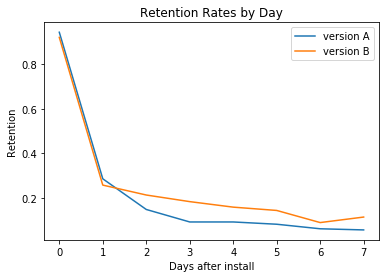

In [21]:
plt.plot(day_retention_A['day_number'][:8], day_retention_A['retention'][:8], label='version A')
plt.plot(day_retention_B['day_number'][:8], day_retention_B['retention'][:8], label='version B')
plt.legend()
plt.xlabel('Days after install')
plt.ylabel('Retention')
plt.title('Retention Rates by Day')
plt.show()



### Next steps

I would recommend following users in variant B for another 11 days so that the time window used to compare the two versions is equivalent. This will allow us to compare monetization rates over equivalent periods and see if there is a difference between the two versions. 

#### Telemetry improvements

We could use some improvements to our tracking to better understand how users play the game: 
    - Enhanced purchase events. We currently only know how much players spend on currency and at what level, not what this money is spent on. What types of boosters are they buying? From this we could better tell if we're offering the right selection of boosters and which ones are most useful for which level. 
    - An event telling us when users uninstall the game from their phone. This would give a clear indication they are unhappy with the game and have completely stopped playing. 